# Data Analysis and Classic Machine Learning Techniques
***
# Table of Contents
1.   [Imports](#Imports)
2.   [Loading The Dataset](#Loading-The-Dataset)
3.   [Data Analysis](#Data-Analysis)
4.   [Data Pre-Processing](#Data-Pre-Processing)
4.   [Different Model Comparison](#Different-Model-Comparison)
5.   [Support Vector Machine](#Support-Vector-Machine)


# Imports

The necessary libraries are imported at this stage.

* pandas - Dataframe object is useful for data processing and analyses.
* sklearn - Provides a number of models, metrics and general functionality for machine learning.
* matplotlib - Provides plotting.

In [16]:
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
#from google.colab import drive #Only needed on Colab
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
%matplotlib inline # Pretty display for notebooks

# Loading The Dataset

In this section we load the dataset from the 2 files.

The training and testing data are loaded from their respective CSV files using the **Pandas** function *read_csv*. The first row in the two datasets are outputted to ensure that the files were read correctly

In [3]:
#mount drive
#drive.mount("/content/drive")
path_to_data = "" #"drive/MyDrive/Kaggle/"

train = pd.read_csv(path_to_data + "train - OG.csv")
test = pd.read_csv(path_to_data + "test.csv")

#Check it loaded ok
display(train.head(n=1))
display(test.head(n=1))

# Data Analysis

In this section analysis over the data is done to determine the processing steps necessary for the [next section](#Data-Pre-Processing).

## Check for Common Elements

The training and test data are merged using inner join to see if there is any overlapping data. The output is an empty data frame - containing only the list of different features - meaning that there are no intersections between the two.

In [6]:
merged = pd.merge(train, test, how='inner')
print(merged)

Empty DataFrame
Columns: [tBodyAcc-mean()-X, tBodyAcc-mean()-Y, tBodyAcc-mean()-Z, tBodyAcc-std()-X, tBodyAcc-std()-Y, tBodyAcc-std()-Z, tBodyAcc-mad()-X, tBodyAcc-mad()-Y, tBodyAcc-mad()-Z, tBodyAcc-max()-X, tBodyAcc-max()-Y, tBodyAcc-max()-Z, tBodyAcc-min()-X, tBodyAcc-min()-Y, tBodyAcc-min()-Z, tBodyAcc-sma(), tBodyAcc-energy()-X, tBodyAcc-energy()-Y, tBodyAcc-energy()-Z, tBodyAcc-iqr()-X, tBodyAcc-iqr()-Y, tBodyAcc-iqr()-Z, tBodyAcc-entropy()-X, tBodyAcc-entropy()-Y, tBodyAcc-entropy()-Z, tBodyAcc-arCoeff()-X,1, tBodyAcc-arCoeff()-X,2, tBodyAcc-arCoeff()-X,3, tBodyAcc-arCoeff()-X,4, tBodyAcc-arCoeff()-Y,1, tBodyAcc-arCoeff()-Y,2, tBodyAcc-arCoeff()-Y,3, tBodyAcc-arCoeff()-Y,4, tBodyAcc-arCoeff()-Z,1, tBodyAcc-arCoeff()-Z,2, tBodyAcc-arCoeff()-Z,3, tBodyAcc-arCoeff()-Z,4, tBodyAcc-correlation()-X,Y, tBodyAcc-correlation()-X,Z, tBodyAcc-correlation()-Y,Z, tGravityAcc-mean()-X, tGravityAcc-mean()-Y, tGravityAcc-mean()-Z, tGravityAcc-std()-X, tGravityAcc-std()-Y, tGravityAcc-std()-Z, t

## Shuffle the data

In [7]:
train = shuffle(train)
test = shuffle(test)

## Check for null values in rows

In [8]:
print("Any missing sample in training set:",train.isnull().values.any())
print("Any missing sample in test set:",test.isnull().values.any(), "\n")

Any missing sample in training set: False
Any missing sample in test set: False 



## Label Distribution

### Label Distribution in a Pie Chart

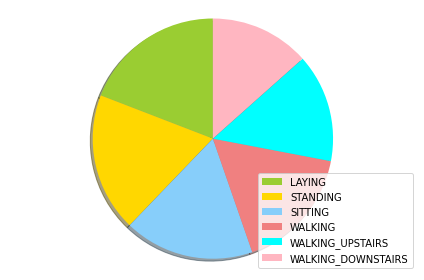

In [9]:
# Visualizing Activity Distribution 
temp = train["Activity"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

### Label Distribution in a Column Format

In [10]:
train_outcome = pd.crosstab(index=train["Activity"],
                              columns="count")

train_outcome

col_0,count
Activity,
LAYING,1407
SITTING,1286
STANDING,1374
WALKING,1226
WALKING_DOWNSTAIRS,986
WALKING_UPSTAIRS,1073


# Data Pre-Processing

The dataset only requires a small number of pre-processing mainly, splitting the sets into X and y variables, categorical
variable encoding (for the label), and scaling.

The *activity* and *subject* columns are removed from the training and test data. **Y_train_label** and **Y_test_label** are the classifications of the activity of each row in the respective dataframes.

In [11]:
X_train = pd.DataFrame(train.drop(['Activity','subject'],axis=1))
Y_train_label = train.Activity.values.astype(object)
X_test = pd.DataFrame(test.drop(['Activity','subject'],axis=1))
Y_test_label = test.Activity.values.astype(object)

print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")

# Transforming non numerical labels into numerical labels
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

# encoding test labels 
encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

#Total Number of Continuous features in the training set
num_cols = X_train._get_numeric_data().columns
print("Number of Continuous Features:",num_cols.size)

#names_of_predictors = list(X_train.columns.values) #Names of each feature

# Scaling the Train and Test feature set 
# Because - values and classification
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #fit_transform is performed on training data
X_test_scaled = scaler.transform(X_test) #transform is performed on test data

Dimension of Train set (7352, 561)
Dimension of Test set (2947, 561) 

Number of numeric features: 561


# Different Model Comparison

In this step we compare 3 classic ml models.

In [12]:
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state=0)
clf_C = SVC(random_state=0)

learners = {}
learners["Gaussian Naive Bayes"] = clf_A
learners["AdaBoost"] = clf_B
learners["Support Vector Machine"] = clf_C

def train_predict(learners, X_train, y_train, X_test, y_test):
  for learner in learners:
    print("Learner:", learner,"\n------")
    print("Training Data")
    start = time()
    learners[learner].fit(X_train, y_train)
    end = time() 
    print("Time taken:", end-start, "seconds")

    print("Testing Data")
    start = time()
    predictions_test = learners[learner].predict(X_test)
    end = time()
    print("Time taken:", end-start, "seconds")

    
    print("\nAccuracy Score")
    print(accuracy_score(y_test,predictions_test))
    
    print("\nBeta Score")
    print(fbeta_score(y_test,predictions_test,beta=0.5,average='weighted'))

    print("\nPrecision Score")
    print(precision_score(y_test, predictions_test, average='weighted'))

    print("\nRecall Score")
    print(recall_score(y_test, predictions_test, average='weighted'),'\n')

train_predict(learners, X_train_scaled, Y_train, X_test_scaled, Y_test)

Learner: Gaussian Naive Bayes 
------
Training Data
Time taken: 0.08500099182128906 seconds
Testing Data
Time taken: 0.08199787139892578 seconds

Accuracy Score
0.7702748557855447

Beta Score
0.7802673518256884

Precision Score
0.7946833707399261

Recall Score
0.7702748557855447 

Learner: AdaBoost 
------
Training Data
Time taken: 19.716001987457275 seconds
Testing Data
Time taken: 0.22099876403808594 seconds

Accuracy Score
0.5310485239226331

Beta Score
0.35512687797924963

Precision Score
0.33628556107901597

Recall Score
0.5310485239226331 

Learner: Support Vector Machine 
------
Training Data
C:\Users\Jake Sant\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Time taken: 2.405998468399048 seconds
Testing Data
Time ta

As can be seen from the above metrics, SVM is quite clearly the most accurate classifier of the three, and it is for that reason that we will use it as one of the main classifiers for the group practical task

# Support Vector Classifier

There are a number of different parameters we can apply to SVC in order to obtain the best results possible. These different parameters were passed through a Grid Search model, which applies all of them to train various SVCs.

In [ ]:
clf = SVC(random_state=0)

parameters =    {
                "kernel": ['poly', 'rbf', 'sigmoid'],
                "C": [50, 10, 1.0, 0.1, 0.01],
                "gamma": ['scale']
                }

scorer = make_scorer(fbeta_score, beta=0.5,average='weighted')
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train_scaled,Y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
clf.fit(X_train_scaled, Y_train)
# Make predictions using the unoptimized and model
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test_scaled)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on the testing data: {:.4f}".format(accuracy_score(Y_test, predictions)))
print("F-score on the testing data: {:.4f}".format(fbeta_score(Y_test, predictions, beta = 0.5,average='weighted')))
print("Precision score on the testing data: {:.4f}".format(precision_score(Y_test, predictions, average='weighted')))
print("Recall score on the testing data: {:.4f}".format(recall_score(Y_test, predictions, average='weighted')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(Y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(Y_test, best_predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(Y_test, best_predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(Y_test, best_predictions, average='weighted')))

In [ ]:
#Confusion Matrix maps out the predicted label given to the data with the actual label
#Helps us check the rate of true/false positives and true/false negatives
#parameters are the true labels, and the predicted labels

print(confusion_matrix(Y_test, best_predictions))
fig, ax = plt.subplots(figsize=(20, 9))
plt.rcParams.update({'font.size': 8})
plot_confusion_matrix(estimator=best_clf, X=X_test_scaled, y_true=Y_test, display_labels=labels, ax=ax, cmap='Greens')
plt.show()

In [ ]:
print("The best parameters were:", grid_fit.best_params_)
